In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import torchvision
import torch.nn as nn
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F

from sklearn.metrics import accuracy_score ,classification_report,confusion_matrix
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
transform = transforms.Compose([
    transforms.Resize((120, 120)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [4]:
# Load the entire dataset
image_dir = "/content/drive/MyDrive/cell_images"
full_dataset = datasets.ImageFolder(image_dir)

train_indices, test_indices = train_test_split(list(range(len(full_dataset))), test_size=0.2, random_state=42)

train_subset = torch.utils.data.Subset(full_dataset, train_indices)
test_subset = torch.utils.data.Subset(full_dataset, test_indices)

train_subset.dataset.transform = transform
test_subset.dataset.transform = transform

trainloader = torch.utils.data.DataLoader(train_subset, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(test_subset, batch_size=32, shuffle=False)

print("Number of images in train set:", len(train_subset))
print("Number of images in test set:", len(test_subset))

Number of images in train set: 22370
Number of images in test set: 5593


In [5]:
class LogisticRegressionModel(nn.Module):
    def __init__(self):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(120 * 120 * 3, 2)

    def forward(self, x):
        out = self.linear(x)
        out = torch.sigmoid(out)
        return out

In [6]:
logModel = LogisticRegressionModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(logModel.parameters(), lr=0.0001)

Epoch 0
Epoch 1
Epoch 2
Finished Training
Test Accuracy: 69.24727337743609


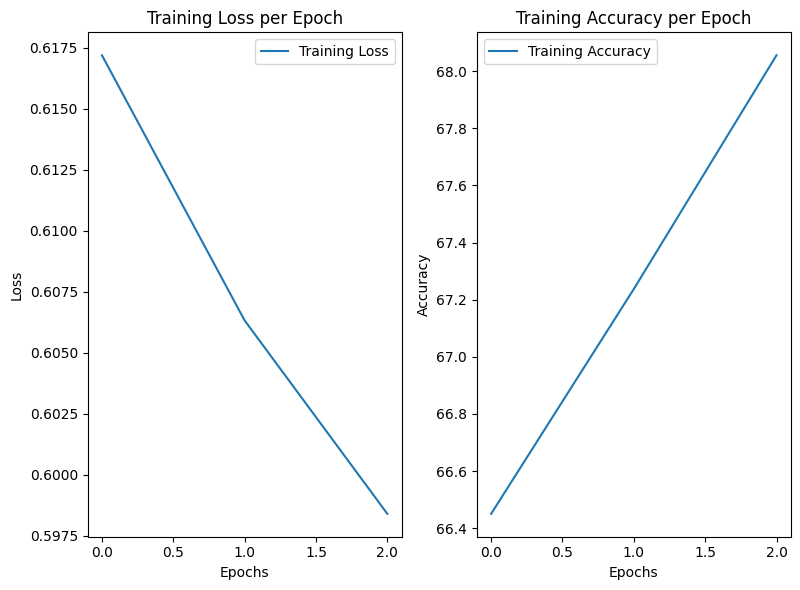

In [7]:
train_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(3):  # loop over the dataset multiple times
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    total_count = 0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()
        inputs = inputs.view(-1, 120 * 120 * 3)

        # forward + backward + optimize
        outputs = logModel(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # calculate training accuracy
        _, predicted_train = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()

        # print statistics
        running_loss += loss.item()
        total_count += 1

    train_losses.append(running_loss / total_count)
    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)
    # print('Training accuracy: %d %%' % train_accuracy)


    print("Epoch", epoch)
    # print('Accuracy of the network on the 10000 test images: %d %%' % test_accuracy)

print('Finished Training')

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.view(-1, 120 * 120 * 3)
        outputs = logModel(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print("Test Accuracy:", test_accuracy)


plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy per Epoch')
plt.legend()

plt.tight_layout()
plt.show()

Accuracy: 0.6925
Classification Report:
              precision    recall  f1-score   support

 Parasitized       0.69      0.73      0.71      2848
  Uninfected       0.70      0.65      0.68      2745

    accuracy                           0.69      5593
   macro avg       0.69      0.69      0.69      5593
weighted avg       0.69      0.69      0.69      5593

Confusion Matrix:
[[2083  765]
 [ 955 1790]]


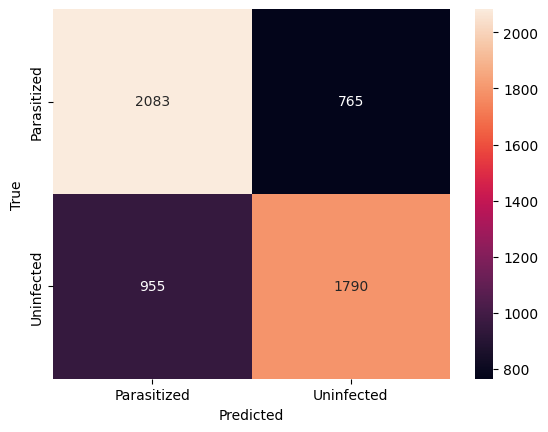

In [8]:
logModel.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in testloader:
        images = images.view(-1, 120 * 120 * 3)
        outputs = logModel(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

class_names = full_dataset.classes

accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {accuracy:.4f}")

# Classification report and confusion matrix
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

print("Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))

# Plot confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()